# SHE (Simplified Hopfield Energy) method 

This method first computes the mean of the internal layer representation of ID data
for each ID class. This mean is seen as the average of the ID activation patterns
as defined in the original paper.
The method then returns the maximum value of the dot product between the internal
layer representation of the input and the average patterns, which is a simplified
version of Hopfield energy as defined in the original paper.

**Reference**
[Out-of-Distribution Detection based on In-Distribution Data Patterns Memorization
with Modern Hopfield Energy](https://openreview.net/forum?id=KkazG4lgKL), ICLR 2023

### Imports


In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

from IPython.display import clear_output
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
import numpy as np

from oodeel.methods import SHE
from oodeel.eval.metrics import bench_metrics
from oodeel.eval.plots import plot_ood_scores, plot_roc_curve, plot_2D_features
from oodeel.datasets import load_data_handler
from oodeel.utils.torch_training_tools import train_torch_model
from oodeel.preprocess import TorchRandomPatchPermutation

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Note that models are saved at _~/.oodeel/saved_models_ and data is supposed to be found
at _~/.oodeel/datasets_ by default. Change the following cell for a custom path.


In [2]:
model_path = os.path.expanduser("~/") + ".oodeel/saved_models"
data_path = os.path.expanduser("~/") + ".oodeel/datasets"
os.makedirs(model_path, exist_ok=True)
os.makedirs(data_path, exist_ok=True)

## First exp: MNIST[0-4] vs MNIST[5-9]

For this first experiment, we train a toy convolutional network on the MNIST dataset
restricted to digits 0 to 4. After fitting the train subset of this dataset to the Gram
method, we will compare the scores returned for MNIST[0-4] (in-distrubtion) and
MNIST[5-9] (out-of-distribution) test subsets.


### Data loading

- In-distribution data: MNIST[0-4]
- Out-of-distribution data: MNIST[5-9]

> **Note:** We denote In-Distribution (ID) data with `_in` and Out-Of-Distribution (OOD)
> data with `_out` to avoid confusion with OOD detection which is the name of the task,
> and is therefore used to denote the core class
> `OODBaseDetector`.


In [3]:
# === Load ID and OOD data ===
batch_size = 128
in_labels = [0, 1, 2, 3, 4]

# 1- Load train/test MNIST dataset
data_handler = load_data_handler("torch")

# 1- Load train/test MNIST dataset
ds_train = data_handler.load_dataset(
    "MNIST", load_kwargs={"root": data_path, "train": True, "download": True}
)
data_test = data_handler.load_dataset(
    "MNIST", load_kwargs={"root": data_path, "train": True, "download": True}
)

# 2- Split ID / OOD data depending on label value:
# in-distribution: MNIST[0-4] / out-of-distribution: MNIST[5-9]
ds_fit, _ = data_handler.split_by_class(ds_train, in_labels)
ds_in, ds_out = data_handler.split_by_class(data_test, in_labels)


# 3- Prepare data (preprocess, shuffle, batch)
def preprocess_fn(inputs):
    inputs["input"] = inputs["input"].float() / 255.0
    return inputs


ds_fit = data_handler.prepare(
    ds_fit, batch_size, preprocess_fn, shuffle=True, columns=["input", "label"]
)
ds_in = data_handler.prepare(
    ds_in, batch_size, preprocess_fn, columns=["input", "label"]
)
ds_out = data_handler.prepare(
    ds_out, batch_size, preprocess_fn, columns=["input", "label"]
)

### Model training

Now let's train a simple model on MNIST[0-4] using `train_torch_model` function.


Test accuracy:	0.991438

=== Penultimate features viz ===


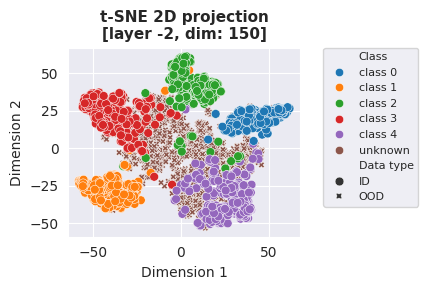

In [4]:
# === Train / Load model ===
# model path
model_path_mnist_04 = os.path.join(model_path, "mnist_mlp_0-4")

try:
    # if the model exists, load it
    model = torch.load(os.path.join(model_path_mnist_04, "best.pt")).to(device)
except OSError:
    # else, train a new model
    train_config = {
        "model": "toy_mlp",
        "num_classes": 10,
        "epochs": 5,
        "save_dir": model_path_mnist_04,
        "validation_data": ds_in,
    }
    model = train_torch_model(ds_fit, **train_config).to(device)
    clear_output()

# evaluate model
model.eval()
labels, preds = [], []
for x, y in ds_in:
    x = x.to(device)
    preds.append(torch.argmax(model(x), dim=-1).detach().cpu())
    labels.append(y)
print(f"Test accuracy:\t{accuracy_score(torch.cat(labels), torch.cat(preds)):.6f}")

# penultimate features 2d visualization
print("\n=== Penultimate features viz ===")
plt.figure(figsize=(4.5, 3))
plot_2D_features(
    model=model,
    in_dataset=ds_in,
    out_dataset=ds_out,
    output_layer_id=-2,
)
plt.tight_layout()
plt.show()

### SHE score

We now fit a SHE detector with MNIST[0-4] train dataset, and compare OOD scores
returned for MNIST[0-4] (ID) and MNIST[5-9] (OOD) test datasets.


In [5]:
%autoreload 2

# === gram scores ===
she = SHE()
she.fit(model, ds_fit, feature_layers_id=["relu1", "relu2"])
scores_in, _ = she.score(ds_in)
scores_out, _ = she.score(ds_out)

# === metrics ===
# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"],
)
print("=== Metrics ===")
for k, v in metrics.items():
    print(f"{k:<10} {v:.6f}")

=== Metrics ===
auroc      0.736096
fpr95tpr   0.645845



=== Plots ===


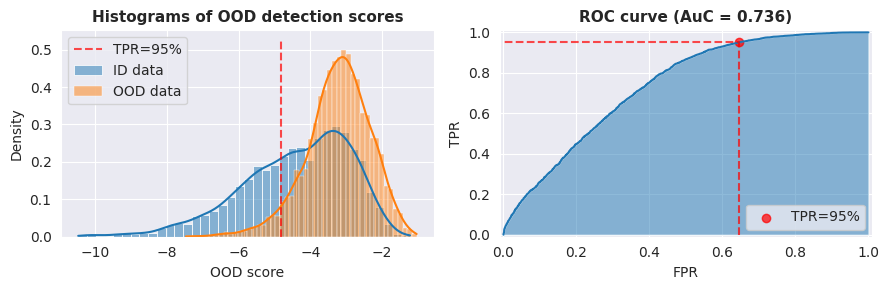

In [6]:
print("\n=== Plots ===")
# hists / roc
plt.figure(figsize=(9, 3))
plt.subplot(121)
plot_ood_scores(scores_in, scores_out)
plt.subplot(122)
plot_roc_curve(scores_in, scores_out)
plt.tight_layout()
plt.show()

## Second exp: CIFAR-10 vs SVHN

For this second experiment, we oppose **CIFAR-10** (in-distribution dataset) to **SVHN**
(out-of-distribution dataset).


### Data loading

- In-distribution data: CIFAR-10
- Out-of-distribution data: SVHN


In [7]:
# === Load ID and OOD data ===
batch_size = 128

data_handler = load_data_handler("torch")

# 1a- Load in-distribution dataset: CIFAR-10
ds_fit = data_handler.load_dataset(
    "CIFAR10", load_kwargs={"root": data_path, "train": True, "download": True}
)
ds_in = data_handler.load_dataset(
    "CIFAR10", load_kwargs={"root": data_path, "train": False, "download": True}
)
# 1b- Load out-of-distribution dataset: SVHN
ds_out = data_handler.load_dataset(
    "SVHN", load_kwargs={"root": data_path, "split": "test", "download": True}
)


# 2- Prepare data (preprocess, shuffle, batch)
def preprocess_fn(inputs):
    """Preprocessing function from
    https://github.com/chenyaofo/pytorch-cifar-models
    """
    inputs["input"] = inputs["input"].float() / 255.0
    inputs["input"] = transforms.Normalize(
        (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
    )(inputs["input"])
    return inputs


ds_fit = data_handler.prepare(
    ds_fit, batch_size, preprocess_fn, shuffle=True, columns=["input", "label"]
)
ds_in = data_handler.prepare(
    ds_in, batch_size, preprocess_fn, columns=["input", "label"]
)
ds_out = data_handler.prepare(
    ds_out, batch_size, preprocess_fn, columns=["input", "label"]
)

clear_output()

### Model loading

The model is a **ResNet20** pretrained on CIFAR-10 and getting an accuracy score of
92.60%, loaded from
[pytorch-cifar-models](https://github.com/chenyaofo/pytorch-cifar-models) repository.


In [8]:
# === load model ===
# resnet20 pretrained on CIFAR-10
model = torch.hub.load(
    repo_or_dir="chenyaofo/pytorch-cifar-models",
    model="cifar10_resnet20",
    pretrained=True,
    verbose=False,
).to(device)
model.eval()
clear_output()

Test accuracy:	0.925900

=== Penultimate features viz ===


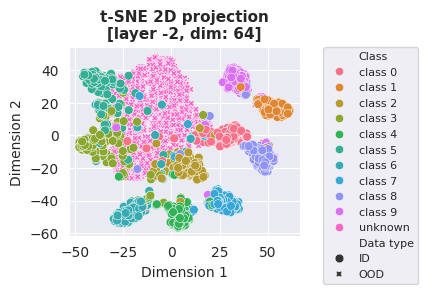

In [9]:
# evaluate model
labels, preds = [], []
for x, y in ds_in:
    x = x.to(device)
    preds.append(torch.argmax(model(x), dim=-1).detach().cpu())
    labels.append(y)
print(f"Test accuracy:\t{accuracy_score(torch.cat(labels), torch.cat(preds)):.6f}")

# penultimate features 2d visualization
print("\n=== Penultimate features viz ===")
plt.figure(figsize=(4.5, 3))
plot_2D_features(
    model=model,
    in_dataset=ds_in,
    out_dataset=ds_out,
    output_layer_id=-2,
)
plt.tight_layout()
plt.show()

### SHE score

We now fit a SHE detector with CIFAR-10 train dataset, and compare OOD scores returned
for CIFAR-10 (ID) and SVHN (OOD) test datasets.


In [10]:
%autoreload 2

# === gram scores ===
she = SHE()
she.fit(model, ds_fit, feature_layers_id=["layer1.2.conv2", "layer2.2.conv2", "layer3.2.conv2"])

scores_in, _ = she.score(ds_in)
scores_out, _ = she.score(ds_out)

=== Metrics ===
auroc      0.990859
fpr95tpr   0.040200

=== Plots ===


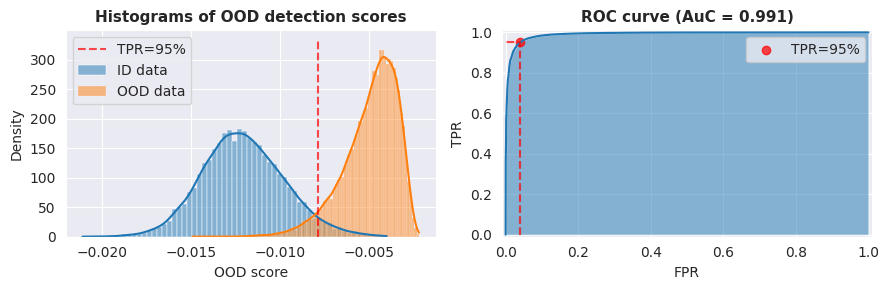

In [12]:
# === metrics ===
# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"],
)
print("=== Metrics ===")
for k, v in metrics.items():
    print(f"{k:<10} {v:.6f}")

print("\n=== Plots ===")
# hists / roc
plt.figure(figsize=(9, 3))
plt.subplot(121)
plot_ood_scores(scores_in, scores_out)
plt.subplot(122)
plot_roc_curve(scores_in, scores_out)
plt.tight_layout()
plt.show()